# AllLife Bank Customer Segmentation

## Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. The Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. There was an insight from the market research that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster.

## Objective

The aim is to come up with  different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

## Data Dictionary

 - __Sl_No:__ Primary key of the records<br>
 - __Customer Key:__ Customer identification number<br>
 - __Average Credit Limit:__ Average credit limit of each customer for all credit cards<br>
 - __Total credit cards:__ Total number of credit cards possessed by the customer<br>
 - __Total visits bank:__ Total number of visits that customer made (yearly) personally to the bank<br>
 - __Total visits online:__ Total number of visits or online logins made by the customer (yearly)<br>
 - __Total calls made:__ Total number of calls made by the customer to the bank or its customer service department (yearly)<br>

## Importing important libraries

In [110]:
import pandas as pd
import numpy as np
from numpy import array

# to perform visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import zscore

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform heirarchical clustering and visualize using graphs
from scipy.stats import zscore
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage

# to perform PCA
#from sklearn.decomposition import PCA

# to remove warnings 
import warnings
warnings.filterwarnings("ignore")

# To display execution time
from datetime import datetime

## Loading and Exploring dataset

In [111]:
df = pd.read_excel('Credit_Card_Customer_Data.xlsx')
print("The dataset has {} rows and {} columns".format(df.shape[0],df.shape[1])) # prints the number of rows and columns of dataset

The dataset has 660 rows and 7 columns


In [112]:
# using random to display random rows rather than only first 5 and last 5
np.random.seed(1)
df.sample(n=10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


In [113]:
df.info() # Function to display the shape, missing values and datatypes of columns in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


 - All the columns are of integer type.<br>
 - There are no null values.

Since the Sl.No column has all unique vaues let us drop it

In [114]:
df = df.drop(['Sl_No'], axis = 1)
df.head()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,87073,100000,2,1,1,0
1,38414,50000,3,0,10,9
2,17341,50000,7,1,3,4
3,40496,30000,5,1,1,4
4,47437,100000,6,0,12,3


In [115]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.5,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.0,10.0


__Observations:__

 - The avg_credit_limit ranges from 3000 to 200000 with and average of 18000.<br>
 - There are customers who have at most 10 credit cards with a minimum being 1. on an average customer owns 5 credit cards.<br>
 - There are customers who do not visit the bank at all while some visit at the max of 5 times. On an average customer visit bank twice.<br>
 - There are customers who frequently visit the bank online, at the max 15 times. We can consider this to be a convenient way of visiting.<br>
 - Total calls made range from 0 to 10. There are customers who never make a call to the customer service and there are few who call frequently.<br>

In [116]:
df.isnull().sum() # function to check for null values

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

There are no null values in the dataset

## Univariate Analysis

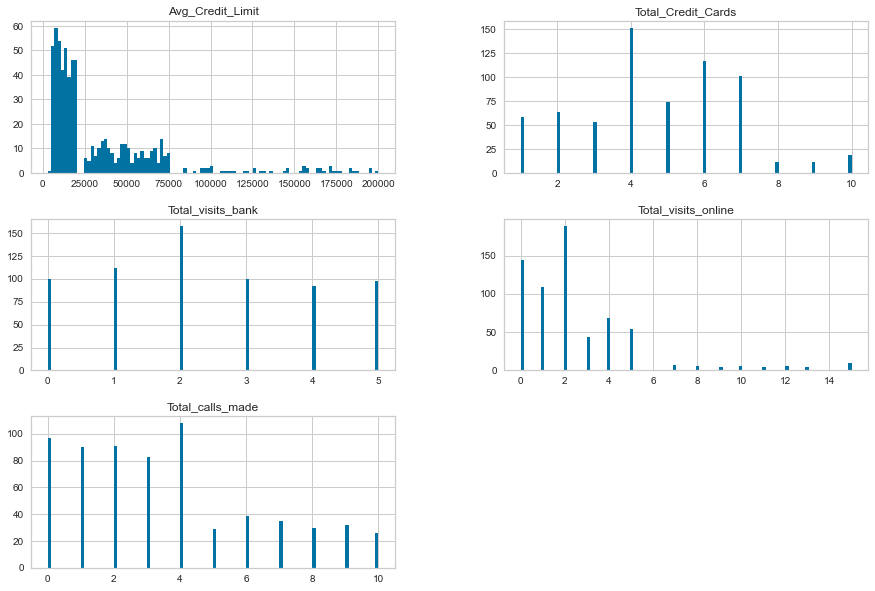

In [117]:
columns = ['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made'] 
df[columns].hist(stacked=False, bins=100, figsize=(15,50), layout=(14,2)); 

__Observations:__

 - The avg_credit_limit ranges from 5000 to 200000. It is right skewed.<br>
 - Majority of customers have 4, 6 or 7 credit cards.<br>
 - The number of bank visits are between 0 to 5 where most of the customers have visited the bank  times.<br>
 - Majority of customers visit the bank online with a frequency of 0 to 5. Very few customer visit the bank often.<br>
 - There are customers who have never called the bank customer service. On an average customer makes 4 calls. There are very few customers who call more than 4 times. This can be either because of poor service when a customer is facing some problem. The customer service is taking too long to resolve issues.

## Bivariate Analysis

In [118]:
df.corr()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Customer Key,1.000000,0.068604,-0.010281,-0.000560,0.022506,0.005968
Avg_Credit_Limit,0.068604,1.000000,0.608860,-0.100312,0.551385,-0.414352
Total_Credit_Cards,-0.010281,0.608860,1.000000,0.315796,0.167758,-0.651251
Total_visits_bank,-0.000560,-0.100312,0.315796,1.000000,-0.551861,-0.506016
Total_visits_online,0.022506,0.551385,0.167758,-0.551861,1.000000,0.127299
Total_calls_made,0.005968,-0.414352,-0.651251,-0.506016,0.127299,1.000000


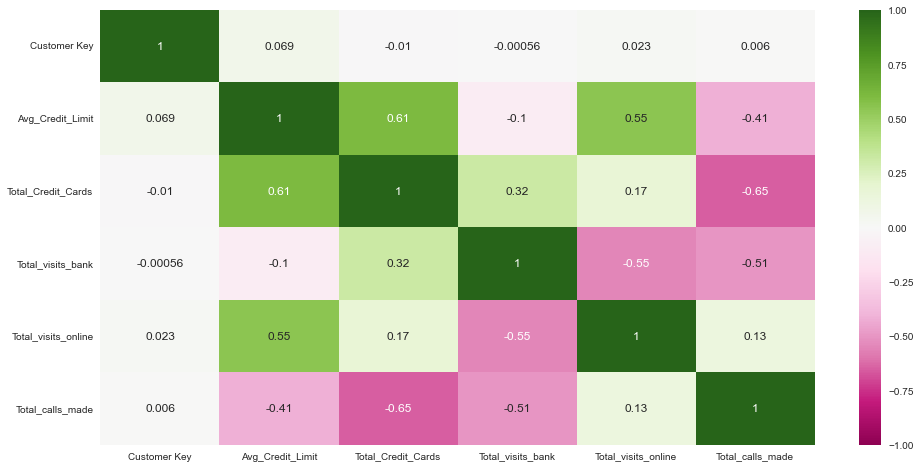

In [119]:
plt.figure(figsize = (16,8))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1,cmap="PiYG");

__Observations:__

 - Avg_credit_limit and Total_credit cards have very high positive correlation.<br>
 - Similarly Avg_credit_limit and Total_visits_online have higher positive correlation. This can be because the customers pay back the credit amount online.<br>
 - Total_Visits_bank and Total_credit_cards also have a positive correlation.<br>
 - Total_calls_made and Avg_credit_limit have a negative correlation.<br>
 - Total_calls_made also have high negative correlation with Total_credit_cards and total_visit_bank.<br>
 - In all the other combinations there is a slight correlation between variables.

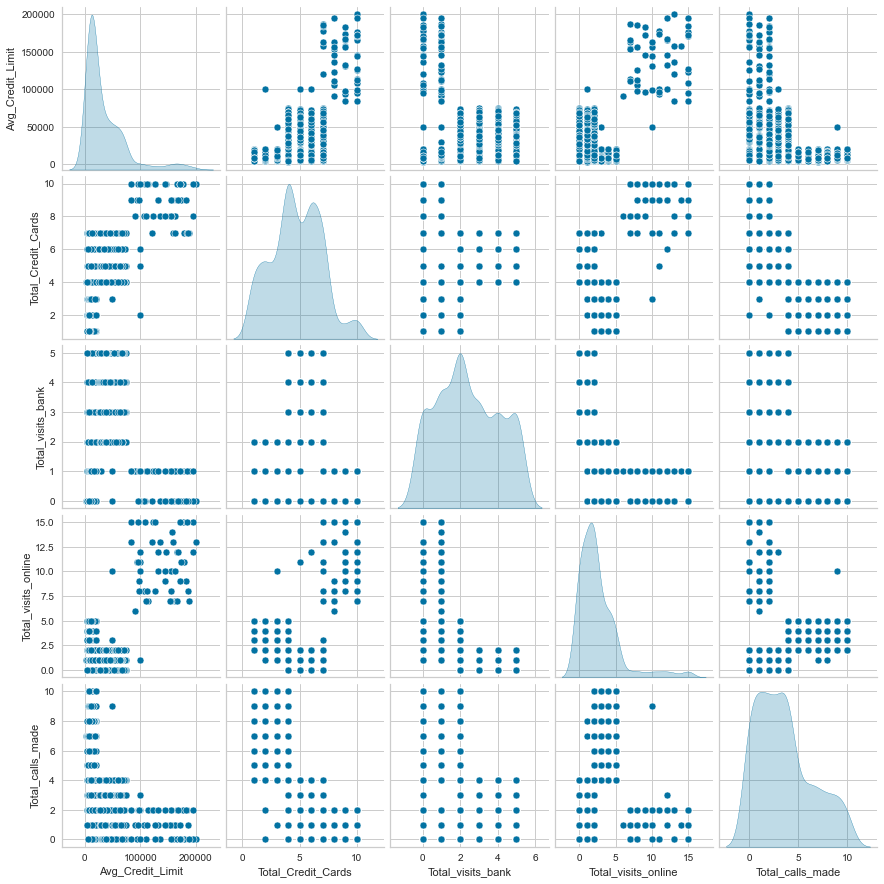

In [120]:
sns.pairplot(df,vars=['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made'],
             diag_kind='kde');

__Observations:__
    
 - Looking at the graph of total_credit_cards, there is a chance that the data might contain 4 customer segments. We can be sure of this with further analysis.<br>
 - From the above graph we can see that Total_credits_cards and Total_visits_online have a positive correlation with Avg_credit_limits.<br>
 - Total_credits_cards and Total_visits_online also have a positive correlation.<br>
 - The relation between other variables is not clear.

## Missing Value Treatment

In [121]:
df.isnull().sum() 

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

The data does not have any null values

## Outlier detection and treatment

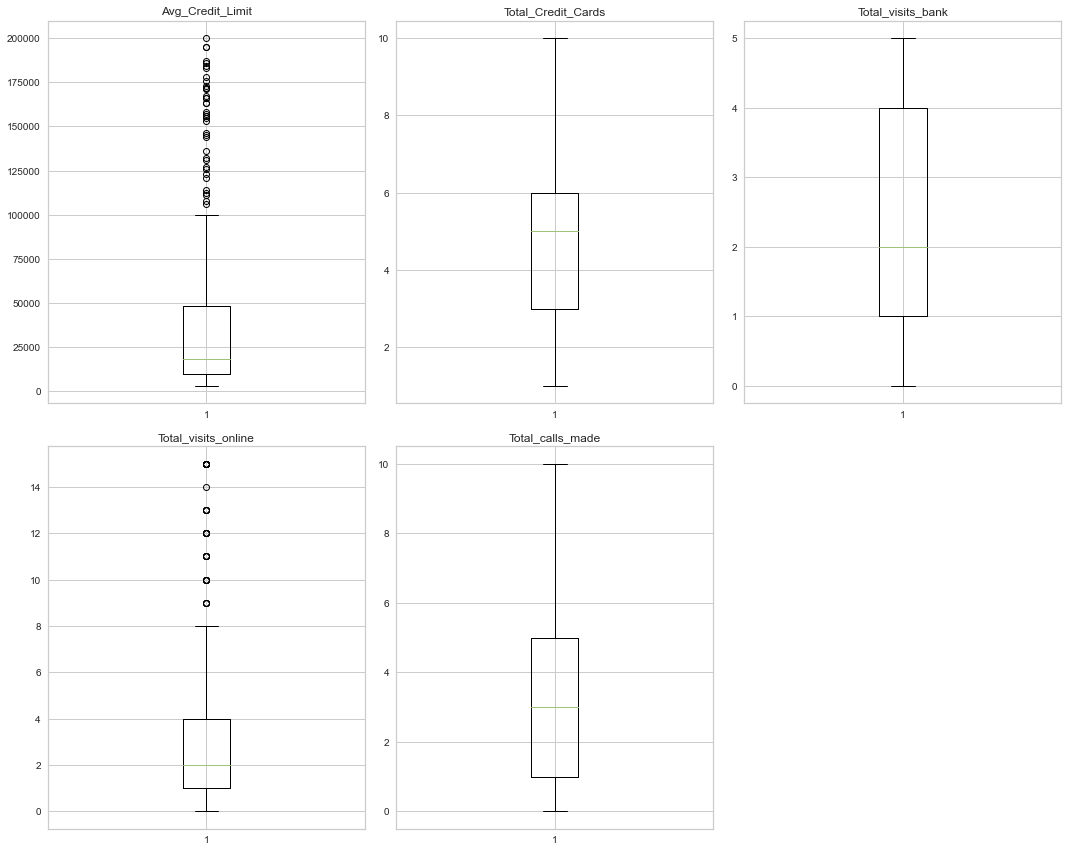

In [122]:
 # list of numerical values in the dataset
columns = ['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']

plt.figure(figsize=(15,12)) # specify the size of each plot

for i, variable in enumerate(columns):
    plt.subplot(2,3, i + 1) # specify where to place each plot
    plt.boxplot(df[variable], whis=1.5) # create boxplot
    plt.tight_layout() # used to adjust the subplots
    plt.title(variable) # set the title to be the column name of that particular plot

plt.show()

In [123]:
Q1 = df[columns].quantile(0.25) # first quantile -> 25% percentile
Q3 = df[columns].quantile(0.75) # second quantile -> 75% percentile

IQR = Q3 - Q1 # Inter quantile range                  

lower_whisker = Q1 - 1.5*IQR # finding the lower bound   
upper_whisker = Q3 + 1.5*IQR # finding the upper bound

# find the percentage of outliers in each column
((df[columns] < lower_whisker) | (df[columns] > upper_whisker)).sum()/df.shape[0]*100 

Avg_Credit_Limit       5.909091
Total_Credit_Cards     0.000000
Total_visits_bank      0.000000
Total_visits_online    5.606061
Total_calls_made       0.000000
dtype: float64

__Observations:__

 - We can see that Avg_credit_limit has outliers. Since some customers have a max of 10 credit cards it can be normal that the credit limit is also more in this case. The number of credit cards is directly proportional to avg_credit_limit.<br>
 - In case of Total_visits_online, it is directly proportional to avg_credit_limit. So let us not remove the outliers this this case as well.<br>
 - Not removing the outliers can come up with a new segment of customers.

## Feature Engineering

### Check for duplicate rows

In [124]:
df.duplicated().sum() # function to check duplicate rows

0

Since Customer Key is unique let us check if there are any duplicates present

In [125]:
df['Customer Key'].duplicated().sum() # function to check duplicate rows

5

In [126]:
cust_key = df['Customer Key']
df[cust_key.isin(cust_key[cust_key.duplicated()])].sort_values("Customer Key")

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,37252,6000,4,0,2,8
432,37252,59000,6,2,1,2
4,47437,100000,6,0,12,3
332,47437,17000,7,3,1,0
411,50706,44000,4,5,0,2
541,50706,60000,7,5,2,2
391,96929,13000,4,5,0,0
398,96929,67000,6,2,2,2
104,97935,17000,2,1,2,10
632,97935,187000,7,1,7,0


Even though the customer keys contain duplicates, the values associated with it are different. The duplicate values might correspond to customer profile changes. Keeping this in mind, let us not drop these duplicate rows.

Customer Key will not be used in further analysis. So let us drop this column.

In [127]:
df = df.drop(['Customer Key'], axis = 1)
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [128]:
data = df.copy()

## Scaling Data

The data contains column Avg_Credit_limit, which has the values to be much higher than the other columns. Hence the distance that will be calculated in the algorithms will end up leaning towards this column. Hence let us scale the data.

In [129]:
df_scaled=df.apply(zscore)
df_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


We can see that the data is scaled and is in the same measure for all the columns.

## K-Means Clustering

In [130]:
num_col = df.columns
num_col

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

### Find K-Means with number of clusters from 1 to 9

In [131]:
start_time = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Execution started at {}".format(start_time))

clusters = range(1, 9)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters=k)  # Initialize KMeans
    model.fit(df_scaled)  # Fit kMeans on the data
    prediction = model.predict(df_scaled)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(df_scaled, model.cluster_centers_, "euclidean"), axis=1))
        / df_scaled.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)
    
end_time = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Execution ended at {}".format(end_time))

Execution started at 19/08/2022 18:21:22
Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990772333470802
Number of Clusters: 6 	Average Distortion: 0.9430843103448057
Number of Clusters: 7 	Average Distortion: 0.9094290022428964
Number of Clusters: 8 	Average Distortion: 0.8891380888508975
Execution ended at 19/08/2022 18:21:25


### Plot Elbow Curve

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

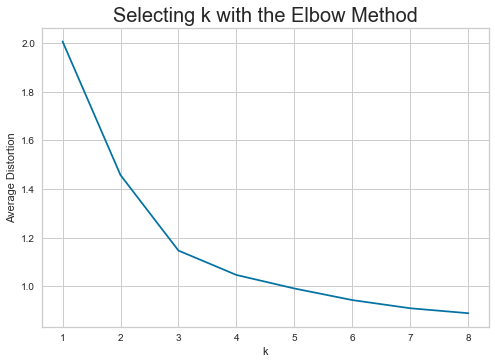

In [132]:
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot

The elbow is knee at k=3. This shows that the optimal number of clusters is 3. We can come up with a final conclusion using silhouette score. Let us find the Silhouette score for all these clusters.

### Calculate the Silhouette score

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2717470361089752
For n_clusters = 6, silhouette score is 0.2560150493463967
For n_clusters = 7, silhouette score is 0.2484780407682755
For n_clusters = 8, silhouette score is 0.2261268477139729
For n_clusters = 9, silhouette score is 0.21993804286643806


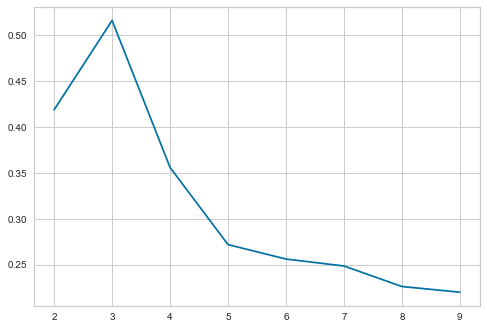

In [133]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((df_scaled))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(df_scaled, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

It seems like 5 is a good value for K. Let us do deeper analysis on this using Silhouette visualizer.

### Interpreting the optimal number of k using Silhouette Visualizer

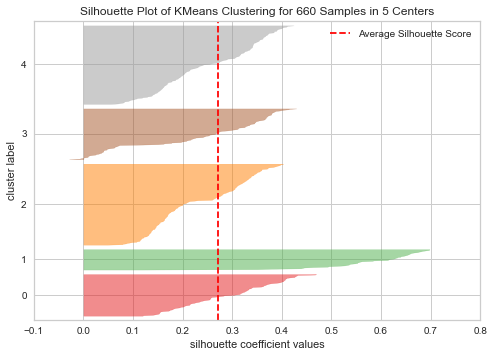

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [134]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(df_scaled)
visualizer.show()

5 is not optimal value of k as it cluster 3 has negative values. Let us visualize k=4.

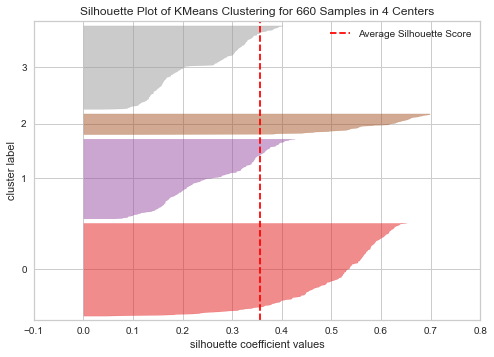

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [135]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(df_scaled)
visualizer.show()

4 is not optimal value of k as clusters 0, 1 and 3 has same width. Let us visualize k=3.

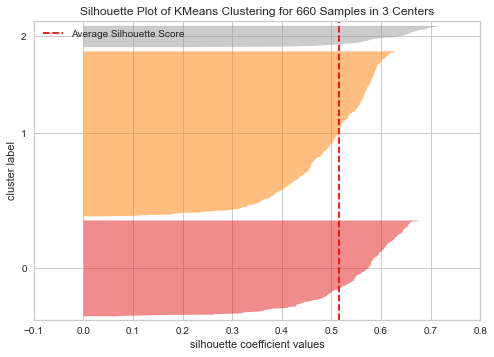

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [136]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(df_scaled)
visualizer.show()

Value k=3 has crossed average silhouette score, has different width, has all positive values, all clusters have different silhouette scores and also has a knee in the elbow curve. Hence __k = 3__ is the right number of clusters since it even has the highest silhouette score.

### Applying K-Means clustering for k=3

In [137]:
df_scaled_kmeans = df_scaled.copy()

In [138]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_scaled_kmeans)

KMeans(n_clusters=3, random_state=0)

In [139]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

### Cluster Profiling

In [140]:
df["K_means_segments"].value_counts()

0    386
1    224
2     50
Name: K_means_segments, dtype: int64

In [141]:
cluster_profile = df.groupby("K_means_segments").mean()

In [142]:
cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000
1,12174.107143,2.410714,0.933036,3.553571,6.870536
2,141040.000000,8.740000,0.600000,10.900000,1.080000


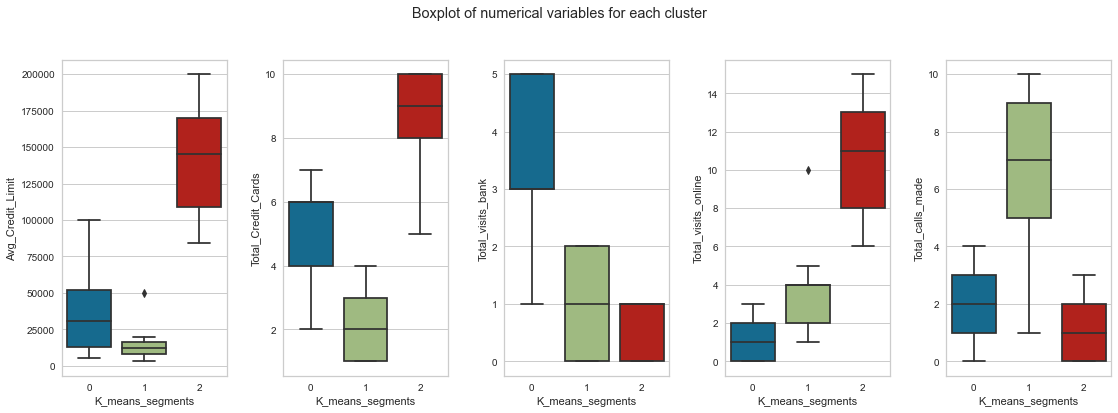

In [143]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

__Cluster 0:__

 - The Avg_credit_limit seems to be in a range of 5000 to 100000.<br>
 - The Avg_credit_limit is also a result of number of credit cards which is in the range 2 to 7.<br>
 - Total visits to ank of this cluster is 1 to 5 times. <br>
 - It can also be seen that customers of his segment have lower online bank visits.<br>
 - The number of calls made are also moderate.<br>
 
__Cluster 1:__

 - The average_credit_limit is very low for these customers who also have less number of credit cards.<br>
 - The customers are spread between both online visits as well as direct visits to the ank. But mostly prefer direct visits.<br>
 - The number of calls made are the highest among this group of customers which shows negligence of the bank customer care.<br>
 
__Cluster 2:__

 - This cluster mostly contains customer who have highest number of credit cards which results in higher credit limits.<br>
 - These customers prefer online visits over direct visits to the bank.<br>
 - The customers of this segment call the bank very less frequently, or this can even show the customer care might mostly prioritise this group of customers which might be a reason for less calls.<br>

### Insights on K-Means Clustering:

 - We can see that the customers were split into 3 segments. 
 - The segmentation was done mostly on the basis of number of credit cards the customer owns.
 - The customers with a higher number of credit cards mostly prefer to visit banks online and the customer service seems to be pretty fine here.
 - The customer with a lower number of credit cards has called the bank multiple times. This might show a poor service of customer care towards this group of customers.

## Heirarchical Clustering

### Calculate the Cophenetic correlation with different linkage methods and different distance measures

In [144]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(df_scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(df_scaled))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801747.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042134.
Cophenetic co

In [145]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


### Let us use Euclidean distance with all other linkage methods

In [146]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(df_scaled, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(df_scaled))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [147]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


#### We can see that the highest cophenetic correlation is with euclidean distance and average linkage.

### Dendrograms for different linkage methods

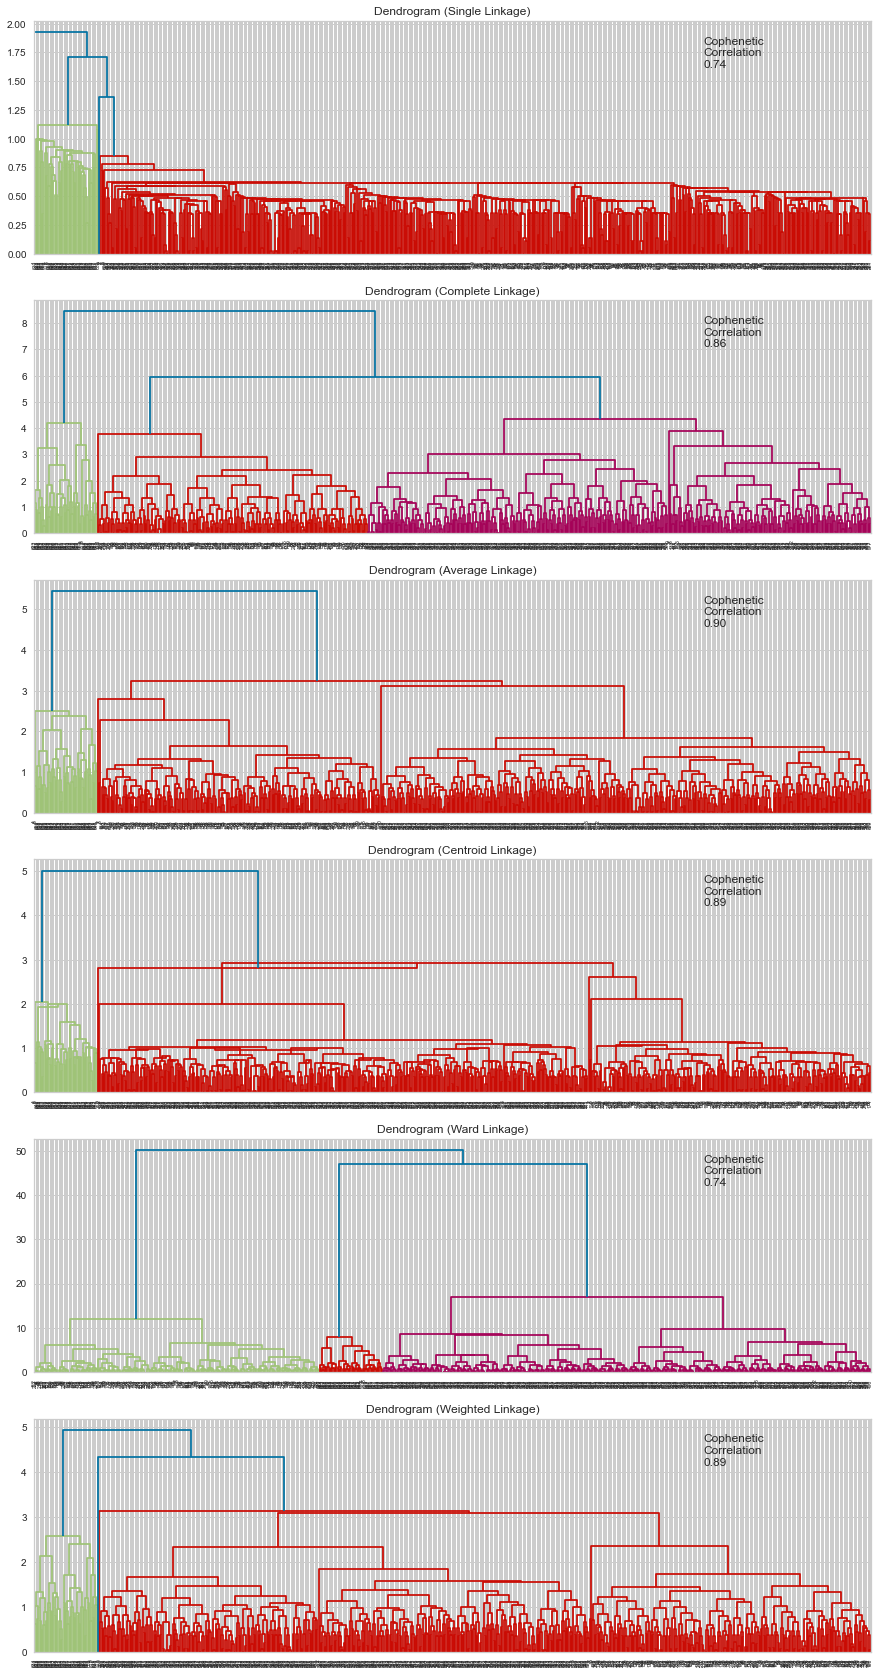

In [148]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(df_scaled, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(df_scaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

__Observations:__

 - The cophenetic correlation is highest for average linkage.<br>
 - Let us consider the dendrogram with average linkage.<br>
 - According to this dendrogram, the number of distinct clusters seems to be 2.


### Let us apply Aglomerative clustering with n_clusters = 2

In [149]:
HCmodel = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="average")
HCmodel.fit(df_scaled)

AgglomerativeClustering(linkage='average')

In [150]:
data["HC_Clusters"] = HCmodel.labels_

### Cluster Profiling

In [151]:
data["HC_Clusters"].value_counts()

0    610
1     50
Name: HC_Clusters, dtype: int64

In [152]:
cluster_profile = data.groupby("HC_Clusters").mean()

In [153]:
cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HC_Clusters,,,,,
0,25847.540984,4.37541,2.55082,1.92623,3.788525
1,141040.000000,8.74000,0.60000,10.90000,1.080000


In [154]:
# let's see the names of the countries in each cluster
for cl in data["HC_Clusters"].unique():
    print("In cluster {}, the number of cards the customers have is in the range:".format(cl))
    print(data[data["HC_Clusters"] == cl]["Total_Credit_Cards"].unique())
    print()

In cluster 0, the number of cards the customers have is in the range:
[2 3 7 5 4 1 6]

In cluster 1, the number of cards the customers have is in the range:
[ 6  5  9  8 10  7]



Both the clusters have distinct values in them. 

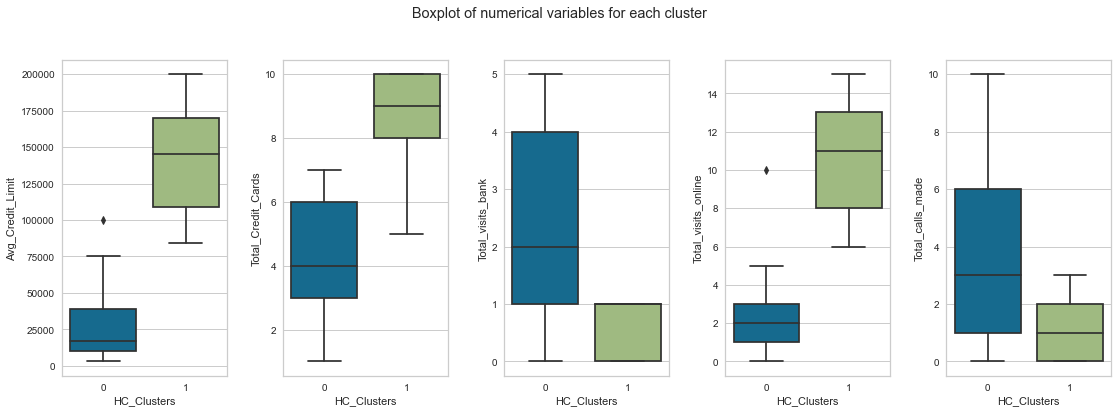

In [155]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=data[num_col[counter]], x=data["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)


__Cluster 0:__

 - The Average_credit_limit is mostly in the range of 3000 to 75000, but there are a very few customers who have a limit of 1000000.<br>
 - This group mostly have the lower number of credit cards.<br>
 - The customers with a lower number of credit cards are most likely seen visiting the bank directly.<br>
 - There is a small group of customers who visit the bank online.<br>
 - Majority of the customers have trouble solving their queries here resulting in a large number of calls made to the bank.<br>
 
__Cluster 1:__

 - The customer segment here has a higher number of credit cards resulting in more average_credit_limit.<br>
 - The customers here have more than 5 cards.<br>
 - This group hardly visits the bank directly. They mostly prefer to visit the bank online.<br>
 - The number of calls made to the bank ranges from 0 to 5.

### Insights on Hierarchical clustering:

 - There optimum number of clusters according to this clustering method is 2.<br>
 - The number of clusters were obtained by using Euclidean distance and Average linkage method.<br>
 - The customers with a higher number of credit cards mostly prefer to visit banks online and the customer service seems to be pretty fine here.<br>
 - The customer with a lower number of credit cards has called the bank multiple times. This might show a poor service of customer care towards this group of customers.<br>

## K-means vs Hierarchical Clustering

- K-Means clustering takes less time to come up with a result when compared to Hierarchical clustering because we have to get dendrograms in case of Hierarchical clustering which is time consuming.<br>
- According to K-Means clustering the ideal number of clusters is 3 while the ideal number of clusters using hierarchical clustering is 4.<br>
- If we compare the number of data points split, based on the count the cluster 0 and cluster 1 of K-Means cluster seems to be combined into cluster 0 in hierarchical clustering.<br>
- The above point can be also cross verified using mean values of the clusters obtained, which shows cluster 2 of K-Means and cluster 1 of hierarchical clustering are the same.<br>
- There is an overlap of features in cluster 0 and cluster 1 of K-Means clustering which shows that Hierarchical clustering has created distinct clusters compared to K-Means.<br>

## Insights

 - The customers having higher number of credit cards have higher credit_limit.<br>
 - There is a very strong correlation of average_credit_limit, number of visits and number of calls with number of cards.<br>
 - The customers with more number of cards most likely visit the bank online while the ones having less number of cards visit the bank directly.<br>
 - The customers having fewer cards make frequent calls to the bank customer care when compared to the customers having a higher number of cards.<br>
 
#### K-Means clustering

 - We can see that the customers were split into 3 segments. 
 - The segmentation was done mostly on the basis of the number of credit cards the customer owns.
 - The customers with a higher number of credit cards mostly prefer to visit banks online and the customer service seems to be pretty fine here.
 - The customer with a lower number of credit cards has called the bank multiple times. This might show a poor service of customer care towards this group of customers.

#### Hierarchical clustering

 - There optimum number of clusters according to this clustering method is 2.<br>
 - The number of clusters were obtained by using Euclidean distance and Average linkage method.<br>
 - The customers with a higher number of credit cards mostly prefer to visit banks online and the customer service seems to be pretty fine here.<br>
 - The customer with a lower number of credit cards has called the bank multiple times. This might show a poor service of customer care towards this group of customers.<br>

#### On comparing results obtained from both the clustering methods, we see that hierarchical clustering have created distinct clusters. Hence we go with this model.

## Recommendations:

 - The customer segments with lower numbers of credit cards have less credit limits. The marketing team has to come up with a strategy to encourage this section of customers to buy more cards by advertising the various benefits available using the credit cards.<br>
 - We see that the customers with fewer cards usually visit the banks directly. Awareness has to be created on how some tasks can be done online, which might save the time of the customers who can get encouraged to buy more cards.<br>
 - We can even see that the customer care is biassed towards the customers having more cards. The operation teams can record the interaction of employees in this sector, so that issues or queries of customers are solved as soon as possible which can attract more customers.